# Building a GAN in 8 simple Steps

## STEP 1.  Importing Necessary Modules


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


## STEP 2. Building A Simple Generator Network


In [0]:

def build_generator():
    #Initializing a neural network
    generator = Sequential()
    
    #Adding an Input layer to the network
    generator.add(Dense(units=256,input_dim=100))    

    #Activating the layer with LeakyReLU activation function
    generator.add(LeakyReLU(0.2))

    #Applying Batch Normalization 
    generator.add(BatchNormalization(momentum=0.8))

    #Adding a second layer	
    generator.add(Dense(units=512))
    
    #Adding a third layer	
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    #The output layer with 784(28x28) nodes
    generator.add(Dense(units=784, activation='tanh'))
    
    #Compiling the Generator Network with loss and optimizer functions
    generator.compile(loss='binary_crossentropy', optimizer= keras.optimizers.adam(lr=0.0002, beta_1=0.5))
    
    return generator

## STEP 3. Building A Simple Discriminator Network

In [0]:

def build_discriminator():
    #Initializing a neural network
    discriminator=Sequential()
    
    #Adding an Input layer to the network
    discriminator.add(Dense(units=1024, input_dim=784))
    
    #Activating the layer with LeakyReLU activation function
    discriminator.add(LeakyReLU(0.2))
    
    #Adding a dropout layer to reduce overfitting
    discriminator.add(Dropout(0.2))
       
    #Adding a second layer
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    #Adding a third layer	 
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    #Adding a forth layer
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.2))
    
    #Adding the output layer with sigmoid activation
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    #Compiling the Discriminator Network with loss and optimizer functions
    discriminator.compile(loss='binary_crossentropy', optimizer = keras.optimizers.adam(lr=0.0002, beta_1=0.5))
    
    return discriminator






*   **The above 2 code blocks simply define two different neural networks. The only major difference between the generator and the discriminator network are the inputs and outputs.**

*   **The generator Network takes random noise as input and tries to recreate the images  from the training set using while the discriminator tries to distinguish the images generated by the generator Network from the actual training Set images.**

*   **The discriminator is a binary classifier while the Generator generates an output similar to the actual images.**


## STEP 4. Building A GAN Network


In [0]:

#Stacking The Generator And Discriminator Networks To Form A GAN

def gan_net(generator, discriminator):
  
    #Setting the trainable parameter of discriminator to False
    discriminator.trainable=False
    
    #Instantiates a Keras tensor of shape 100 (Noise shape)
    inp = Input(shape=(100,))
    
    #Feeds the input noise to the generator and stores the output in X
    X = generator(inp)
    
    #Feeds the output from generator(X) to the discriminator and stores the result in out
    out= discriminator(X)
    
    #Creates a model include all layers required in the computation of out given inp.
    gan= Model(inputs=inp, outputs=out)
    
    #Compiling the GAN Network
    gan.compile(loss='binary_crossentropy', optimizer = 'adam')
    
    return gan

*   **The above method when invoked creates a GAN by stacking the generator and discriminator networks.**

*   **The trainable parameter of the discriminator network when set to false freezes the weights in the discriminator network while the generator network is trained. This prevents the discriminator network from being updated while the generator generates new images from noise.**

*   **The input shape to the GAN network is the shape of the noise. The noise is fed to the generator and its output is fed to the discriminator which classifies the image as original or generated.**


## STEP 5. Plotting The Generated Images


In [0]:
#Method to plot the images
def plot_images(epoch, generator, dim = (10,10), figsize=(10,10)):
    #Generate a normally distributed noise of shape(100x100)
    noise= np.random.normal(loc=0, scale=1, size=[100, 100]) 
    #Generate an image for the input noise
    generated_images = generator.predict(noise)
    #Reshape the generated image 
    generated_images = generated_images.reshape(100,28,28)
    
    #Plot the image 
    plt.figure(figsize=figsize)
   
    #Plot for each pixel
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i],cmap='gray', interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

**The above method generates plots for the images created by the generator from the normally distributed noise input.** 





## STEP 6. Method For Training


In [0]:

#Traing method with training set, default epoch and default batch_size as arguments.

def train(X_train, epochs=5, batch_size=128):
    
    
    #Initializing the GAN 
    generator= build_generator()
    discriminator= build_discriminator()
    gan = gan_net(generator,discriminator)
    
    
    # Training the model for specified epochs
    
    for epoch in range(1,epochs+1 ):
        print("###### @ Epoch ", e)
        
        #tqdm module helps to generate a status bar for training 
        for _ in tqdm(range(batch_size)):
          
            #Random noise with size batch_sizex100
            noise= np.random.normal(0,1, [batch_size, 100])
            
            #Generating images from noise
            generated_images = generator.predict(noise)
            
            #taking random images from the training set 
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Creating a new training set with real and fake images 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)  
            y_dis[:batch_size]=1.0 # label for real images
            
            #Training the discriminator with real and generated images
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Labelling the generated images a sreal images(1) to trick the discriminator
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            #Freezing the weights of the discriminator while training generator
            discriminator.trainable=False
            
            #Training the gan network
            gan.train_on_batch(noise, y_gen)
        
        #Plotting the images for every 10 epochs
        if epoch == 1 or epoch % 10 == 0:
          plot_images(e,generator,dim = (10,10) , figsize=(15,15))

## STEP 7.  Loading And Processing MNIST Data


In [0]:
#Unpacking the training data from mnist data dataset
(X_train, _), (_, _) = mnist.load_data()

#Converting to float type and normalizing the data
X_train = (X_train.astype(np.float32) - 127.5)/127.5

# convert shape of X_train from (60000, 28, 28) to (60000, 784) - 784 columns per row
X_train = X_train.reshape(60000, 784)


## STEP 8. Training The GAN

W0812 07:03:23.543608 140651392956288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 07:03:23.565021 140651392956288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 07:03:23.568110 140651392956288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 07:03:23.668240 140651392956288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0812 07:03:23.757938 

###### @ Epoch  1


  3%|▎         | 4/128 [00:00<00:03, 31.89it/s]

###### @ Epoch  2


  3%|▎         | 4/128 [00:00<00:03, 35.88it/s]

###### @ Epoch  3


  3%|▎         | 4/128 [00:00<00:03, 35.45it/s]

###### @ Epoch  4


  3%|▎         | 4/128 [00:00<00:03, 32.61it/s]

###### @ Epoch  5


100%|██████████| 128/128 [00:03<00:00, 34.02it/s]


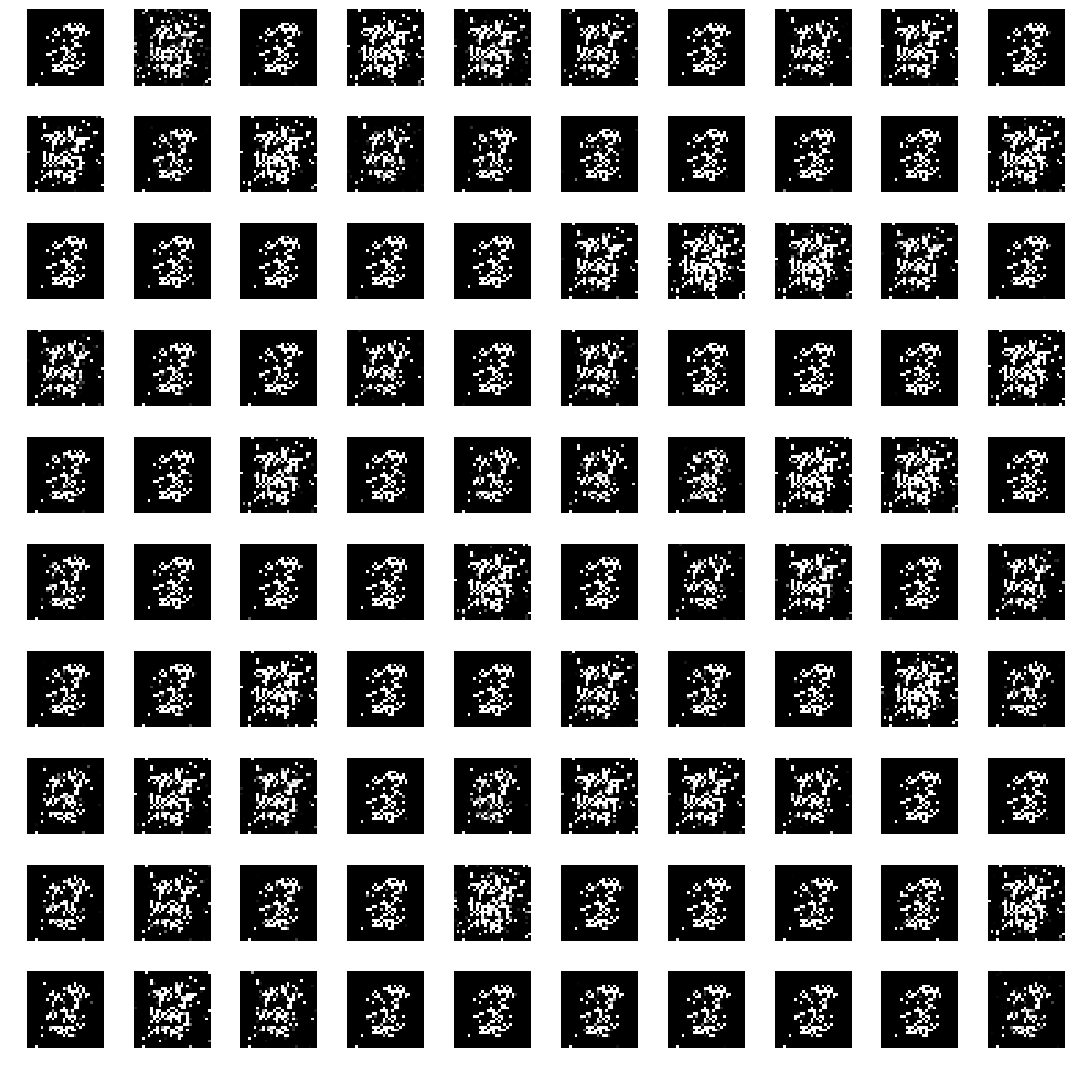

In [0]:
train(X_train,epochs = 5, batch_size = 128)

**Thanks to Renu Khandelwal's [Generative Adversarial Network(GAN) using Keras](https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3)!**
